# **Segmentação Semântica**

A segmentação semântica da imagem é a tarefa de classificar cada pixel em uma imagem a partir de um conjunto pré-definido de classes. No exemplo a seguir, são classificadas diferentes entidades. Em particular, nosso objetivo é pegar uma imagem de tamanho H x W x 3 e gerar uma matriz H x W contendo os ID's de classe previstos correspondentes a todos os pixels.

<img src='https://divamgupta.com/assets/images/posts/imgseg/image14.png'>

# Importando as bibiliotecas

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import keras
import math
import os
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow.keras.backend as K

# **Baixando o dataset**

Neste exercício, utilizaremos um conjunto de dados de vestuário chamado
Clothing Co-Parsing (CCP). Consiste em 2.098 fotos de grande variedade de moda de rua em alta resolução com grandes variações, que estão em uma ampla gama de estilos, acessórios, peças de vestuário e pose. Em comparação com as bases de dados deste segmento existentes, esta base de dados inclui desafios mais realistas, por exemplo, fundos desordenados, grandes variações intraclasse, diferentes poses/visões, e oclusões.


<img src="https://raw.githubusercontent.com/bearpaw/clothing-co-parsing/master/example.jpg"> </img>

Originalmente, temos anotação para 57 diferentes classes, contudo, iremos fazer um mapeamento destas 57 classes em apenas 4:
- 0 (null -- background)
- 1 (pele)
- 2 (cabelo)
- 3 (roupas)

In [2]:
# Autentica e cria um cliente PyDrive.
# Este passo precisar ser executado apenas uma vez por notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1G23UQLTWrp-LdRpFjqd_9Rw_4iOzPznm' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('clothing-dataset.zip')

In [3]:
!unzip clothing-dataset.zip

Archive:  clothing-dataset.zip
   creating: dataset/
  inflating: dataset/x_test.npy      
  inflating: dataset/x_train.npy     
  inflating: dataset/y_test.npy      
  inflating: dataset/y_test_onehot.npy  
  inflating: dataset/y_train.npy     
  inflating: dataset/y_train_onehot.npy  


A base da dodos é composta por 4 arquivos principais, são eles:
- ``x_train.npy``: este arquivo contém as imagens que serão utilizadas como entrada na etapa de treinamento
- ``y_train.npy``: arquivo que contém as máscaras dos dados contidos no arquivo ``x_train.npy``
- ``x_test.npy``: contém as images que serão utilizadas para o conjunto de validação
- ``y_test.npy``: contém as máscaras das imagens do conjunto de validação.  

In [4]:
#Definimos os tamanhos das imagens que serão utilizadas para treino e validação
IMG_HEIGHT = 384
IMG_WIDTH = 256
BATCH_SIZE = 8

x_train = np.load('dataset/x_train.npy').astype(np.float32)
x_val = np.load('dataset/x_test.npy').astype(np.float32)
y_train = np.load('dataset/y_train_onehot.npy').astype(np.float32)
y_val = np.load('dataset/y_test_onehot.npy').astype(np.float32)

## Funções Auxiliares

In [5]:
# show results using each model
def show_result(model, x, y, IMG_HEIGHT = 384, IMG_WIDTH = 256):
    if len(x) != len(y):
        raise Exception('Check the number of images and labels')
    else:
        pass

    x = x.reshape([1, IMG_HEIGHT, IMG_WIDTH, 3])
    pred = model.predict(x)
    pred = np.argmax(pred, axis = 3)

    y = y.reshape([1, IMG_HEIGHT, IMG_WIDTH, 4])
    gt = np.argmax(y, axis = 3)

    total = np.unique(gt).shape[0]
    cmap = plt.get_cmap('RdBu', total + 1)

    fig = plt.figure(figsize = (12, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(x)[:,:,::-1])
    plt.axis('off')
    plt.title('Imagem')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(gt), cmap=cmap)
    plt.axis('off')
    plt.title('Real')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred), cmap=cmap)
    plt.axis('off')
    plt.title('Predito')
    plt.show()
    return


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)


smooth = 1.

# Rede de Segmentação U-Net

Para este exercício, iremos utilizar uma rede conhecida como U-Net. Esta foi originalmente inventada e utilizada pela primeira vez para a segmentação de imagens médicas. Sua arquitetura pode ser amplamente considerada como uma rede encoder-decoder com skip-connections (similar ao modelo ResNet). Para esta atividade, vamos codificar uma arquitetura U-Net.
<img src="https://lapix.ufsc.br/wp-content/uploads/2018/10/u-net-architecture.png"> </img>



## Código

In [6]:
!pip install -q keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.1 MB/s eta 0:00:00


In [7]:
import keras
from keras import models
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, \
    MaxPooling2D, Input, Concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras_cv

import os

augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomColorDegeneration(0.2),
        keras_cv.layers.ChannelShuffle(),
    ],
)

class UNet(object):
    def __init__(self, img_shape, num_of_class, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape da imagem de entrada
        num_of_class - numero de classes
        actf - funcao de ativacao da rede
        learning_rate - learning rate para treinamento
        drop_rate - taxa do dropout
        do_batch_norm - se utilizaremos batchnormalization
        do_drop - se utilizaremos dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4

    # construcao da rede
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(dec_path)
        segmented = Activation('softmax')(segmented)

        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate),
                          loss = 'categorical_crossentropy', metrics = [dice_coef, 'accuracy'])

        return model

    # treino do modelo
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        self.history = self.model.fit(X_train, Y_train, validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # treinamento com aumentações
    def train_generator(self, x_train, y_train, x_test, y_test, name_model, epoch = 10, batch_size = 32, val_split = 0.2, min_lr = 1e-06):

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            brightness_range=[0.7, 1.3],
            preprocessing_function=augmenter,
        )

        val_datagen = ImageDataGenerator(
            rescale=1./255
        )

        train_gen = train_datagen.flow(
            x_train,
            y_train,
            batch_size = batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            x_test,
            y_test,
            batch_size = batch_size,
            shuffle=False
        )

        save_dir = './save_model/'
        if not os.path.exists(save_dir): # caso nao exista, criaremos a pasta
            os.makedirs(save_dir)

        cb_checkpoint = ModelCheckpoint(save_dir + name_model + '.keras', monitor = 'val_accuracy', save_best_only = True)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 5, min_lr = min_lr)

        self.history = self.model.fit(train_gen,
                                      validation_data=val_gen,
                                      epochs=epoch,
                                      callbacks=[cb_checkpoint, reduce_lr])
        return self.history

    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)
        return pred_classes

    # show architecture
    def show_model(self):
        return print(self.model.summary())

    # reuse model
    def saved_model_use(self, save_dir = None):

        self.model.load_weights(save_dir)

Using TensorFlow backend


# **Treinamento do modelo**

In [8]:
model = UNet(img_shape = x_train[0].shape, num_of_class = 4,learning_rate = 5e-4)

In [9]:
history = model.train_generator(x_train, y_train,
                                x_val, y_val,
                                'UNet_model',
                                epoch = 30,
                                batch_size = BATCH_SIZE)

Epoch 1/30
113/113 [==============================] - 81s 352ms/step - loss: 0.6304 - dice_coef: 0.8088 - accuracy: 0.7960 - val_loss: 0.6307 - val_dice_coef: 0.7782 - val_accuracy: 0.7526 - lr: 5.0000e-04
Epoch 2/30
113/113 [==============================] - 26s 226ms/step - loss: 0.3401 - dice_coef: 0.9049 - accuracy: 0.8838 - val_loss: 0.2942 - val_dice_coef: 0.9225 - val_accuracy: 0.9025 - lr: 5.0000e-04
Epoch 3/30
113/113 [==============================] - 26s 227ms/step - loss: 0.2584 - dice_coef: 0.9311 - accuracy: 0.9116 - val_loss: 0.2731 - val_dice_coef: 0.9269 - val_accuracy: 0.9043 - lr: 5.0000e-04
Epoch 4/30
113/113 [==============================] - 26s 228ms/step - loss: 0.2252 - dice_coef: 0.9405 - accuracy: 0.9206 - val_loss: 0.2242 - val_dice_coef: 0.9412 - val_accuracy: 0.9261 - lr: 5.0000e-04
Epoch 5/30
113/113 [==============================] - 26s 227ms/step - loss: 0.1995 - dice_coef: 0.9476 - accuracy: 0.9319 - val_loss: 0.1910 - val_dice_coef: 0.9495 - val_accu

# **Carregando o modelo para predições**

Por fim, uma vez que temos o modelo treinado, iremos carregar o melhor modelo para inferência.

In [10]:
from keras.models import load_model
unet = load_model('./save_model/UNet_model.keras', compile=False)

É muito importante lembrar que precisamos aplicar a mesma normalização utilizada em tempo de treino nos dados de validação e teste. Assim, vamos normalizar os dados de entrada da imagem e da sua respectiva máscara.

In [11]:
x_val /= 255.
y_val /= 255.

Dado que o nosso conjunto de teste já está pronto, selecionamos ao acaso 5 imagens do conjunto de teste.

1/1 [==============================] - 1s 1s/step


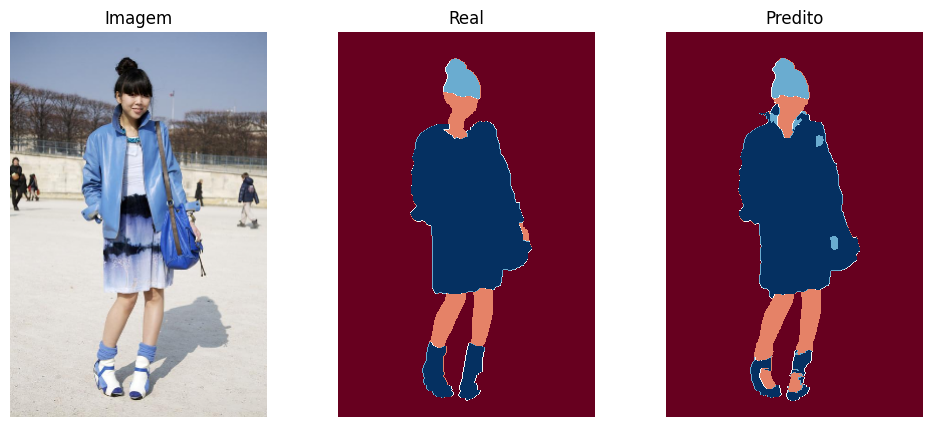

1/1 [==============================] - 0s 22ms/step


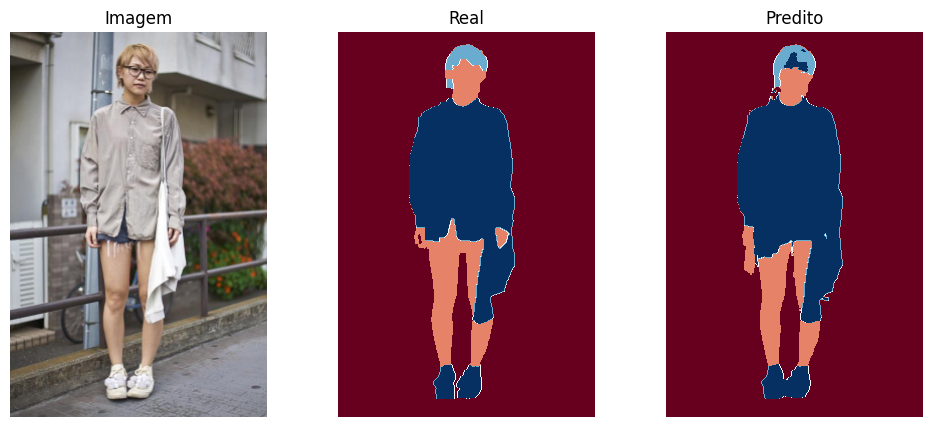

1/1 [==============================] - 0s 21ms/step


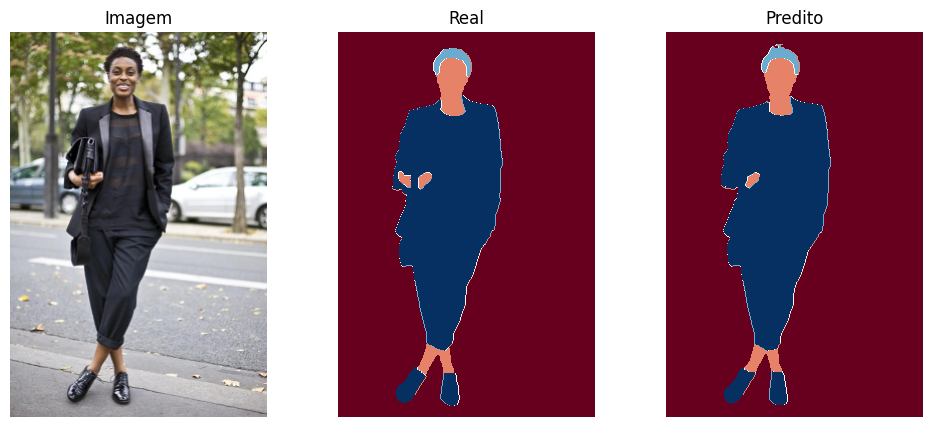

1/1 [==============================] - 0s 23ms/step


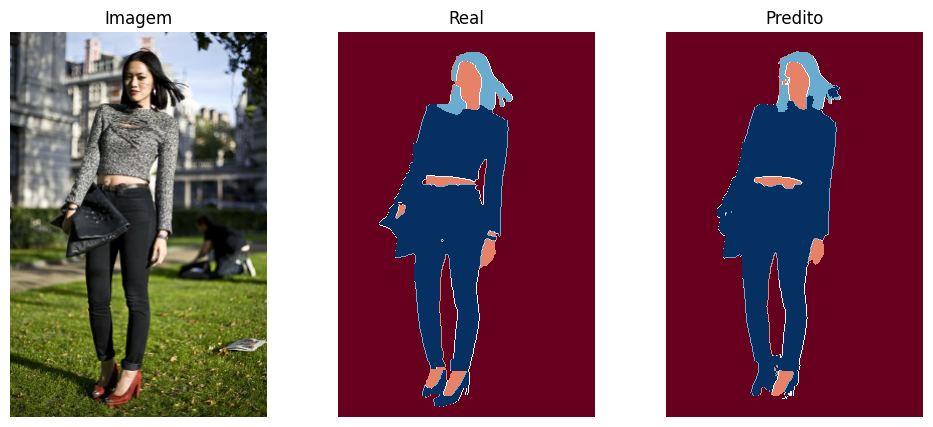

1/1 [==============================] - 0s 21ms/step


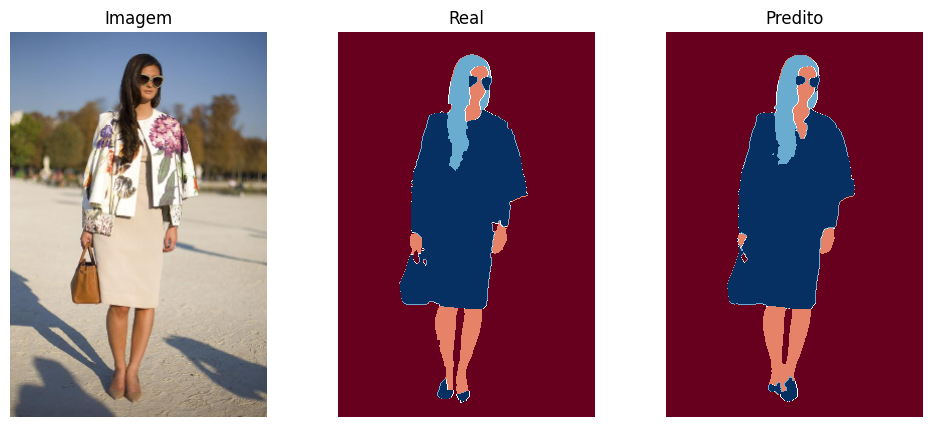

In [12]:
for image_num in np.random.choice(x_val.shape[0], size=5):
    show_result(unet, x_val[image_num], y_val[image_num])

# Testando o modelo com imagens da internet

1/1 [==============================] - 0s 279ms/step


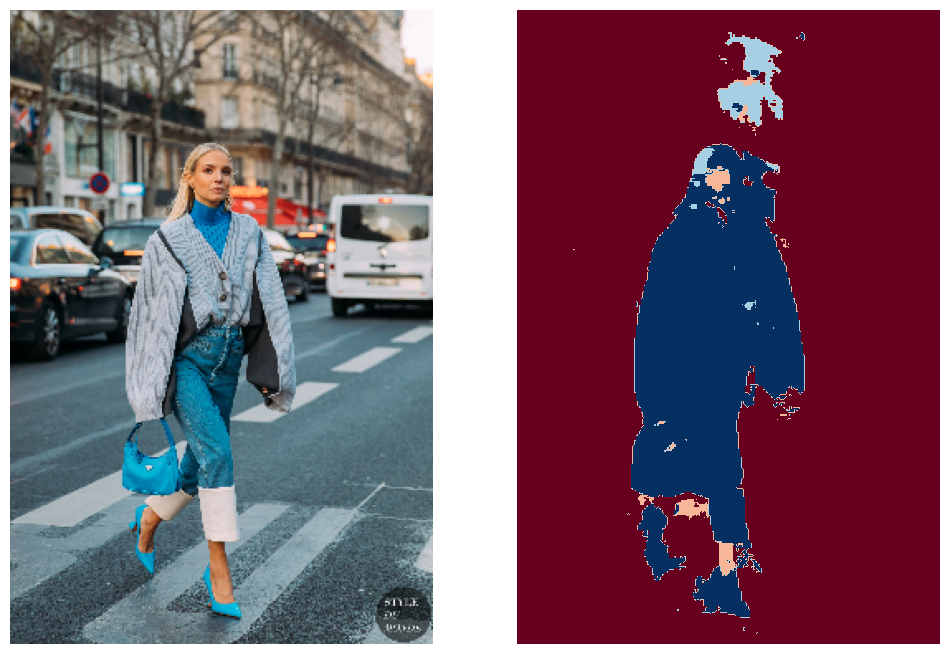

1/1 [==============================] - 0s 23ms/step


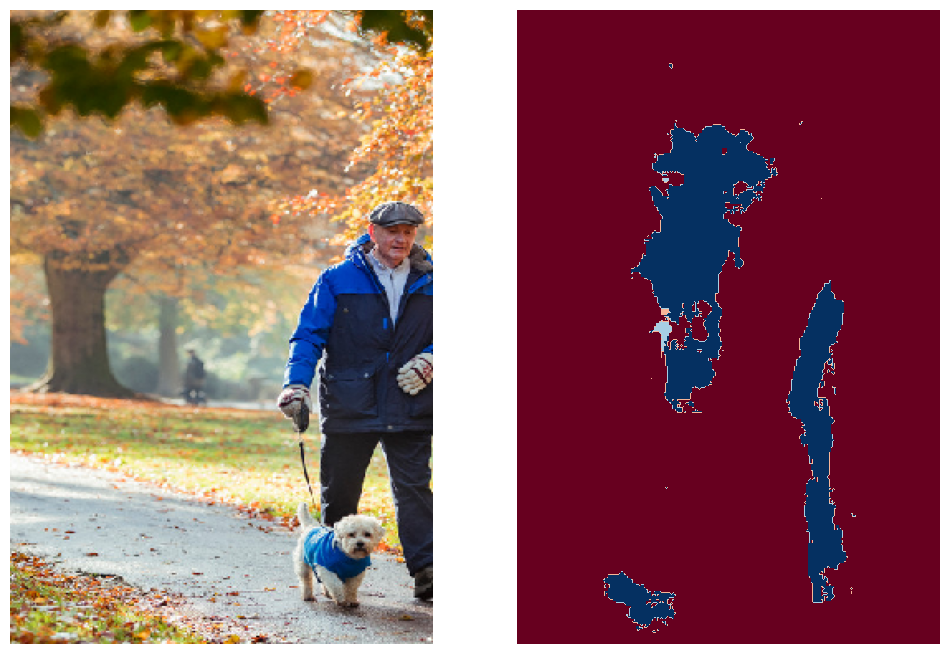

1/1 [==============================] - 0s 22ms/step


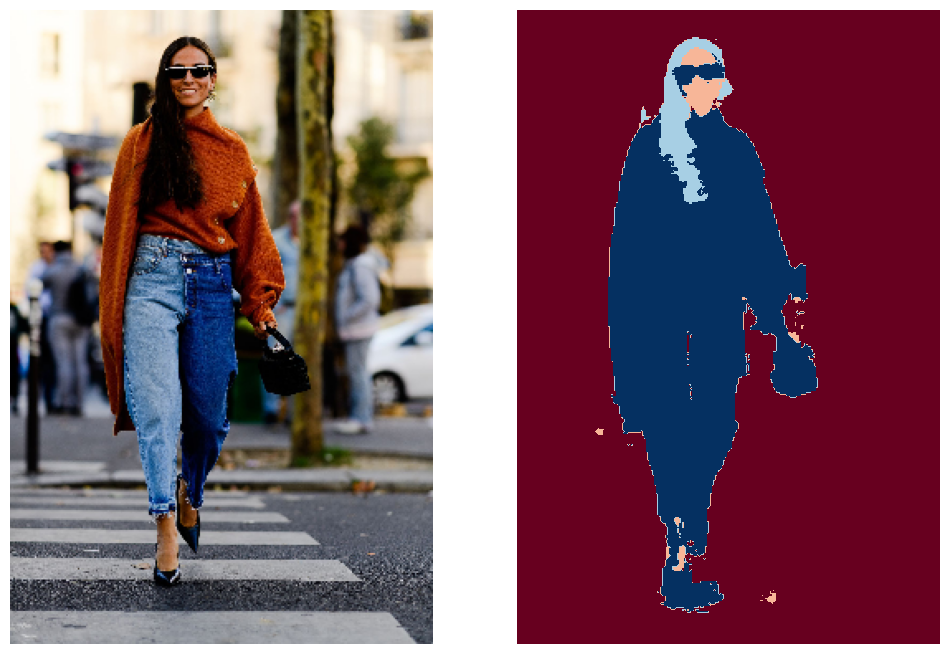

1/1 [==============================] - 0s 21ms/step


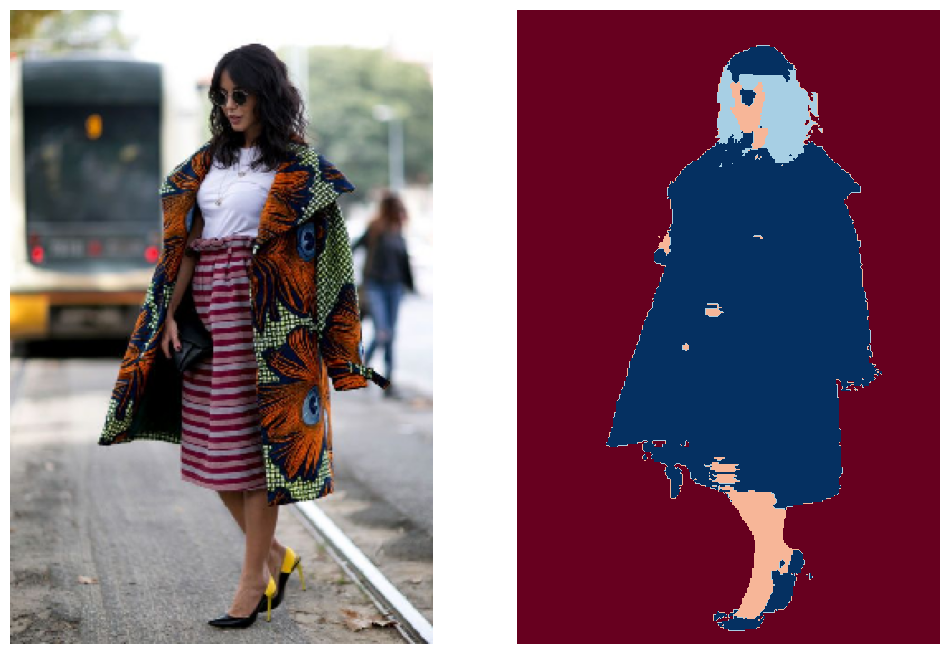

In [13]:
import tensorflow as tf
from PIL import Image, ImageOps
from tensorflow.keras.utils import load_img

# Lista de imagens para teste:
list_images = ['https://i.pinimg.com/originals/fe/1d/98/fe1d98f7b4f34894022fc98cee6a7f77.png',
'https://wutv29.com/resources/media/c53081a0-ef04-4cf4-8b39-9e4061b5bddb-small9x16_GettyImages1148020444.jpg',
'https://i.pinimg.com/originals/5b/88/27/5b88271c58ab45f06a23e72550ff52e3.jpg',
'https://i.pinimg.com/originals/e4/43/08/e44308a5ca4ac17b63afe7009804e39c.jpg']


def display_mask(pred):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(pred, axis=3)
    plt.imshow(np.squeeze(mask), cmap= plt.get_cmap('RdBu', 4))

for idx, url_image in enumerate(list_images):
  # carrega imagem da url
  img_path = tf.keras.utils.get_file(str(idx)+'.png', url_image)
  img = load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH))
  img_np = np.array(img)
  img_np = np.expand_dims(img_np, axis=0)

  # predição do modelo
  pred = model.predict(img_np)

  # plot imagem e predição
  f = plt.figure(figsize=(12, 14))
  f.add_subplot(1,2, 1)
  plt.imshow(Image.fromarray(img_np[0]))
  plt.axis('off')
  f.add_subplot(1,2, 2)
  plt.axis('off')
  display_mask(pred)
  plt.show(block=True)